# Autoencoders - adapt neural network into unsupervised learning

Neural nets can be used for both classification and regression problems
they can also contribute to unsupervised learning problems

Classification
Regression
Unsupervised

supervised - this is cat - this is dog - what this is?
unsupervised - these are the total images - figure out the similarity in these


Using neural networks for unsupervised learning

![image](https://i0.wp.com/sefiks.com/wp-content/uploads/2018/03/autoencoder.jpeg)


## Autoencoding has 2 outputs
Autoencoder Neural Network
their design make them special 

- they have same nodes for both input and output
- Hidden layers must be symmetric about the center
- The number of nodes in hidden layer decrease from left to center
- increase from center to right

### Also
- Input features are reduced and restored respectively
- input can be compressed as the value of centroid layer's
- if input is same as output
- compression operation is not lossless
    
    auto encoder - reduction
    
    auto decoder - enlargement
    
    
Discard the labels

In [15]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from tensorflow.keras.datasets import mnist
import numpy as np

from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

In [12]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# we will forget about the y part or the lables of images 
# with labels it is - supervised
# without labels it is - unsupervised - 
# we dont know what is round known as (p.s. zero)

x_train = x_train.astype('float32')/255.0
x_test = x_test.astype('float32')/255.0

# x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
# x_test  = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.reshape(x_train.shape[0], np.prod(x_train.shape[1:]))
x_test  = x_test.reshape(x_test.shape[0], np.prod(x_test.shape[1:]))



In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

instances, input_features = x_train.shape

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten

In [4]:
model = Sequential()
model.add(Dense(128, activation='relu', input_shape=(784,)))
model.add(Dense( 32, activation='relu')) # symmetric centroid
model.add(Dense(128, activation='relu'))
model.add(Dense(784, activation='sigmoid'))


In [8]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train, x_train, epochs=3, validation_data=(x_test,x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 5s 91us/sample - loss: 0.0916 - accuracy: 0.8141 - val_loss: 0.0891 - val_accuracy: 0.8132
Epoch 2/3
60000/60000 [==============================] - 5s 80us/sample - loss: 0.0893 - accuracy: 0.8143 - val_loss: 0.0876 - val_accuracy: 0.8133
Epoch 3/3
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0879 - accuracy: 0.8144 - val_loss: 0.0866 - val_accuracy: 0.8135


In [9]:
model.save('mnist_autoencoder.h5')

In [11]:
def test_restoration(model):
    decoded_imgs = model.predict(x_test)
    get_3rd_layer_output = K.function([model.layers[0].input], [model.layers[1].output])
    
    for i in range(2):
        print('orignal')
        plt.imshow(x_test[i].reshape(28,28))
        plt.show()
        
        print('reconstructed')
        plt.imshow(decoded_imgs[i].reshape(28,28))
        plt.show()
        
        print('compressed')
        current_compressed = get_3rd_layer_output([x_test[i:i+1]])[0][0]
        plt.imshow(current_compressed.reshape(8,4))
        plt.show()

orignal


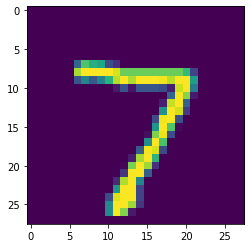

reconstructed


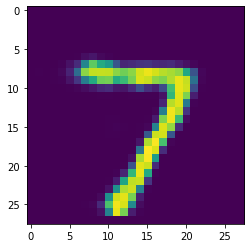

compressed


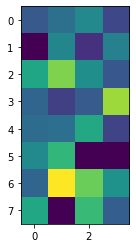

orignal


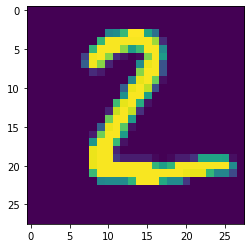

reconstructed


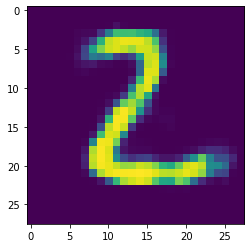

compressed


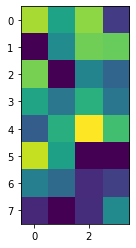

In [16]:
test_restoration(model)

In [19]:
# the restored ones are blurred, but are clearly readable
# compressed representation is still meaningful

# we dont need to show all the representations,
# we can directly save the compressed versions

def autoencode(model):
    decoded_imgs = model.predict(x_test)
    get_3rd_layer_output = K.function([model.layers[0].input],[model.layers[1].output])
    compressed = get_3rd_layer_output([x_test])
    return compressed

com = autoencode(model)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 128)               4224      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               101136    
Total params: 209,968
Trainable params: 209,968
Non-trainable params: 0
_________________________________________________________________


In [28]:
len(com[0][0]) # 32 pixels in one image
len(com[0]) # 1000

10000

## Results
The input image was of 784 whereas compressed rep is of 32

it is 24 times smaller than the original image

Herein, complex input features enforces traditiona unsupervised learning algo
k-means and knn

if all features are included, it will confuse the algo
idea is you should apply the auto-encoder, reduce input features and extract meaningful data first. 

Then apply unsupervised learning to compressed representation. so clustering algorithm works high performance and provide meaningful results

### why autoencoder and decoder are not differently trained ?
the input is the image and the output is the image
so the middle layer of the network depends upon the whole layer
and during training it is modified or updated!! 

if we would use both alone, then we will just get some random compressed output that is just not the good one as we dont have the final result to check the loss function on that.

in the other codes we use - trained models on imagenet and remove the last layers of that network to generate the input.
so the hidden layers are already trained and optimized with the label of that class
so no need to train the model again
but here again we are defining the model from scratch so have to train 
and for training we optimize the loss function and moreover we need the input and specific output for the model as that is SUPERVISED - once we are sure the model is learning perfectly - we just use that for predictions and compressing the images

In [35]:
from tensorflow.compat.v1.estimator.experimental.ops import clustering_ops

unsupervised_model = tf.compat.v1.estimator.experimental.KMeans(
    10,
    distance_metric = clustering_ops.SQUARED_EUCLIDEAN_DISTANCE,
    initial_clusters = tf.contrib.learn.KMeansClustering.RANDOM_INIT
    )

def train_input_fn():
    data = tf.constant(com[0], tf.float32)
    return (data, None)

unsupervised_model.fit(input_fn=train_input_fn, steps=5000)
clusters = unsupervised_model.predict(input_fn=train_input_fn)

index = 0
for i in clusters:
    current_clusters = i['cluster_idx']
    features = x_test[index]
    index = index + 1

ModuleNotFoundError: No module named 'tensorflow.compat.v1.estimator.experimental.ops'